In [129]:
import os
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
from scipy import stats



#Feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler



#importing machine learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle



#Secondary imports
import pandas_profiling as pp
from scipy.stats import pearsonr
import pickle


%matplotlib inline

## Reading Datasets

In [164]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

cols = np.load('final_col.npy').tolist()

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (746,835) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (700,731,740,752,761,789,811,820,829,841,850) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [131]:
len(cols)

234

In [132]:
remove = []

for i in range(len(cols)):
    value = (1 - train[train[cols[i]]!=0].shape[0]/train.shape[0]) * 100
    if value > 60:
        remove.append(cols[i])


for i in range(len(remove)):
    cols.remove(remove[i])

### Finding missing values, and selecting  columns with less than 5% missing values

In [133]:
seta = cols.copy()

In [134]:
percent_missing = train[seta].isnull().sum() * 100 / len(train[seta])
missing_value_df = pd.DataFrame({'column_name': train[seta].columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_df.reset_index(inplace=True, drop=True)

In [135]:
mis_col = missing_value_df[missing_value_df['percent_missing']<5].sort_values('percent_missing', ascending=False).column_name.values.tolist()

In [136]:
len(cols)

167

In [137]:
len(mis_col)

167

In [138]:
rf = RandomForestClassifier()


#Creating features from training dataset
features1 = train[mis_col]


targets = train['Col2']

rf.fit(features1, targets) 

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = mis_col,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


         importance
Col10          0.03
Col11          0.03
Col196         0.03
Col26          0.02
Col182         0.02
Col168         0.02
Col186         0.02
Col205         0.02
Col202         0.02
Col25          0.02
Col198         0.02
Col591         0.01
Col189         0.01
Col188         0.01
Col51          0.01
Col120         0.01
Col1028        0.01
Col75          0.01
Col49          0.01
Col1008        0.01
Col1029        0.01
Col68          0.01
Col1050        0.01
Col1078        0.01
Col1272        0.01
Col1024        0.01
Col1026        0.01
Col1014        0.01
Col1666        0.01
Col1006        0.01
...             ...
Col1710        0.00
Col1239        0.00
Col1347        0.00
Col62          0.00
Col1219        0.00
Col1279        0.00
Col84          0.00
Col1253        0.00
Col1056        0.00
Col90          0.00
Col1631        0.00
Col86          0.00
Col64          0.00
Col1036        0.00
Col1527        0.00
Col1167        0.00
Col1229        0.00
Col1009        0.00


In [139]:
threshold = 0.001

In [140]:
thres_col = sorted(feature_importances[feature_importances.importance > threshold].reset_index()['index'].values.tolist(), key = lambda x: int(x[3:]))
print(len(thres_col))

167


In [141]:
thres_col.remove('Col32')

In [142]:
thres_col.remove('Col33')

In [143]:
train_data = train[thres_col]
test_data = test[thres_col]

Col10 16328


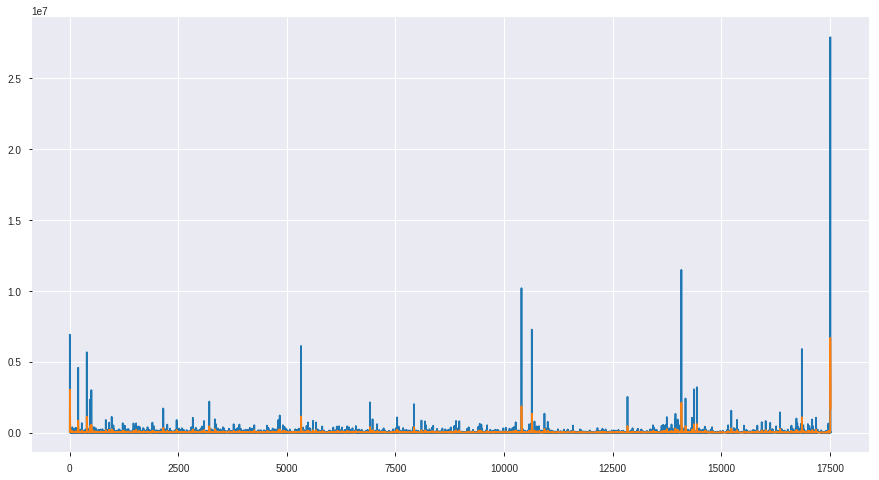

Col11 16319


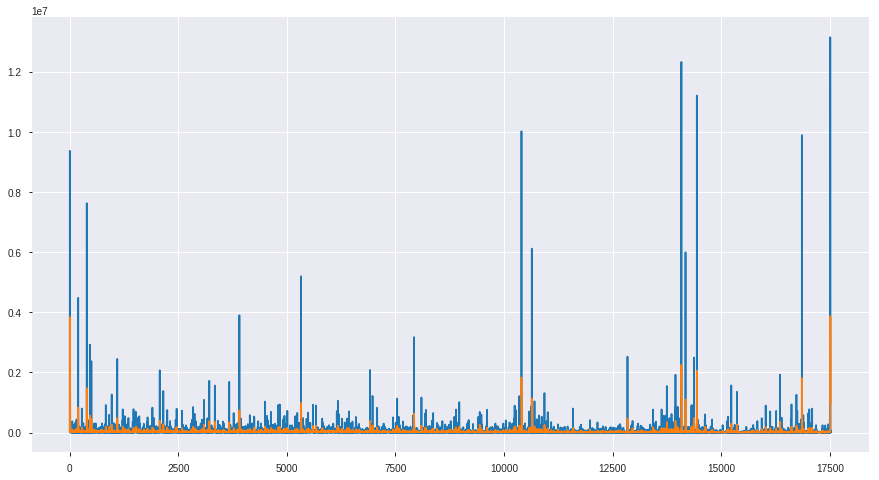

Col25 16163


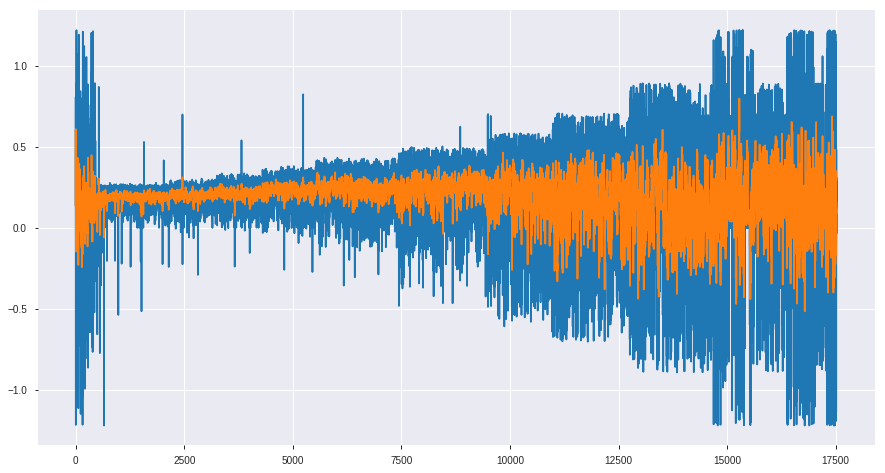

Col26 16108


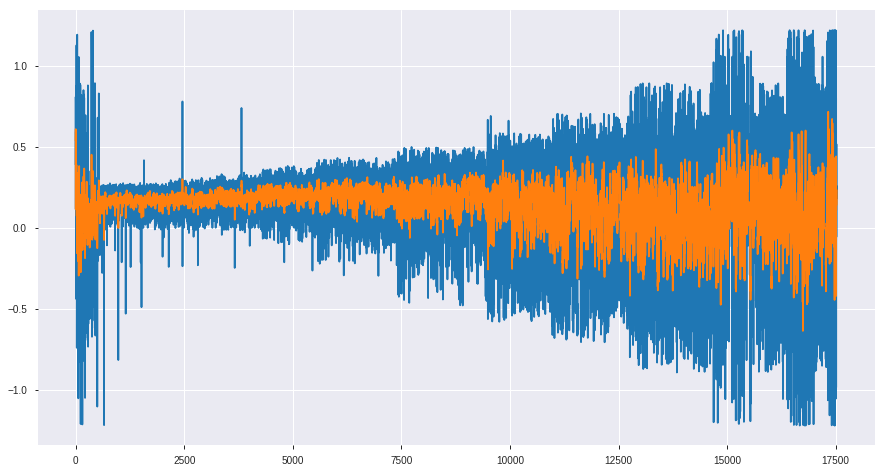

Col168 16231


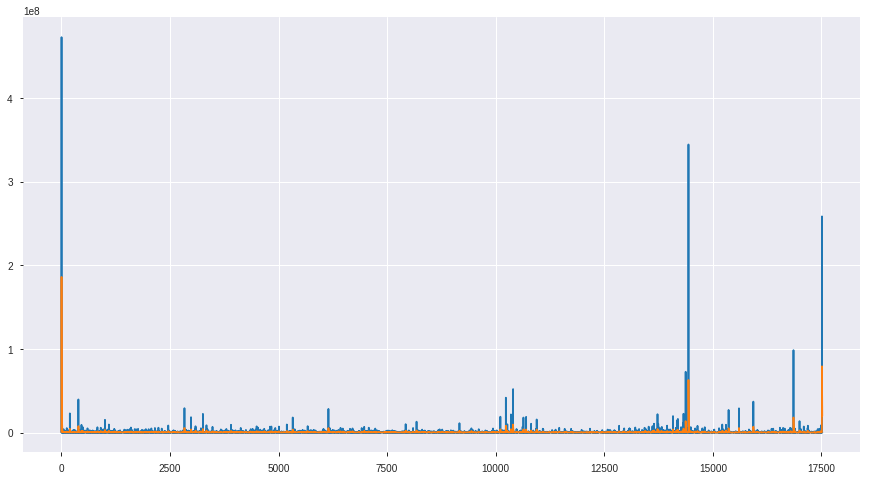

Col182 815


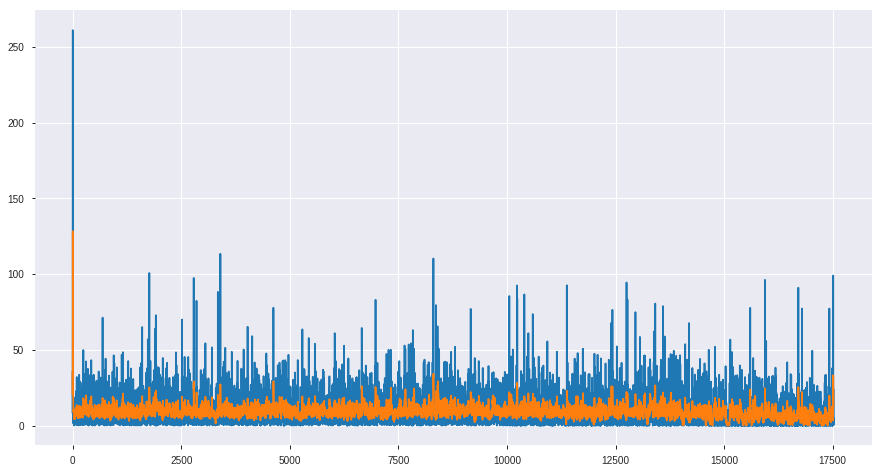

Col186 278


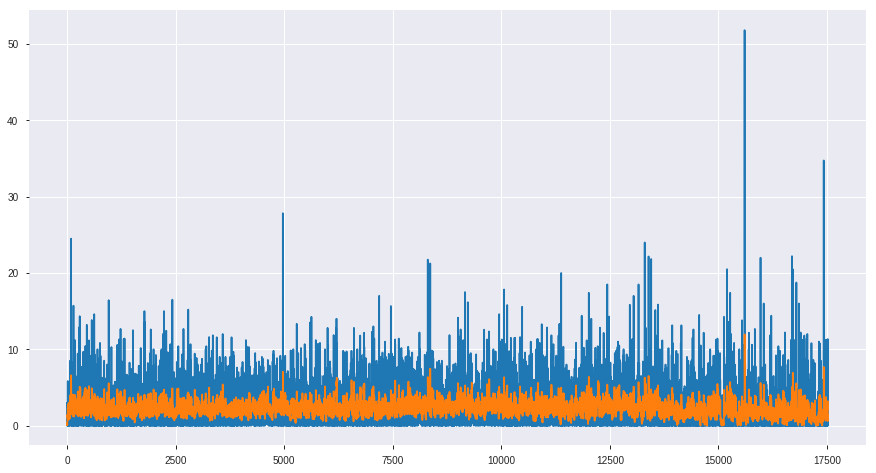

Col188 515


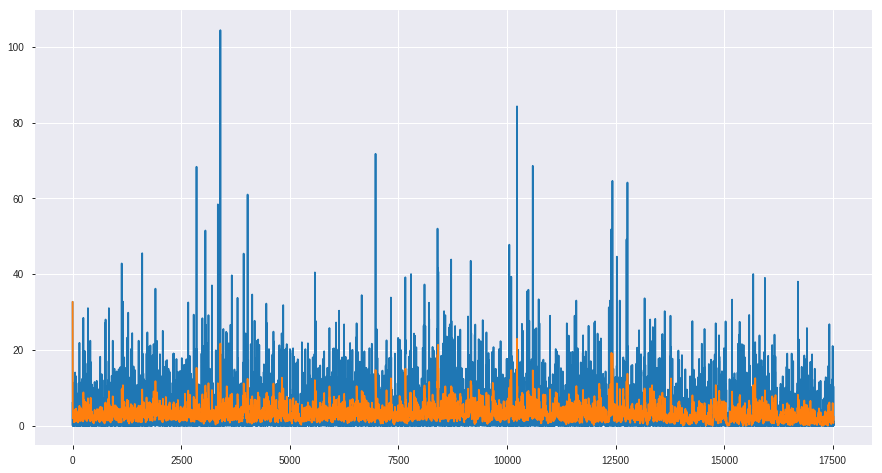

Col189 337


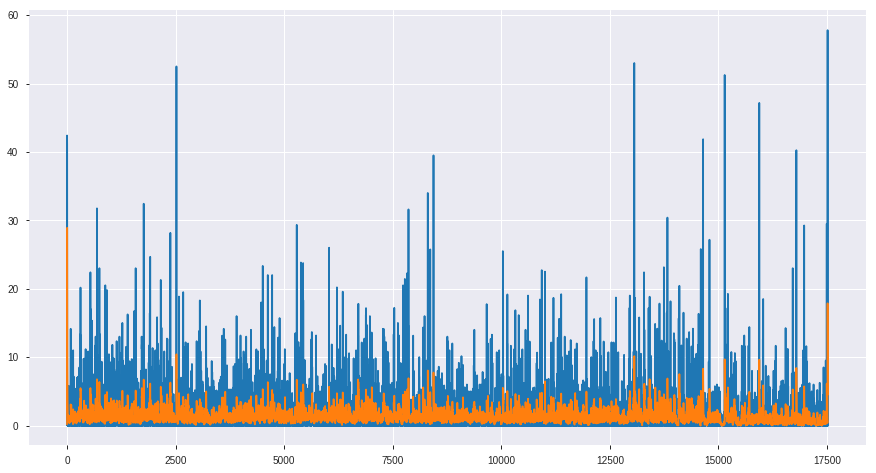

Col196 3806


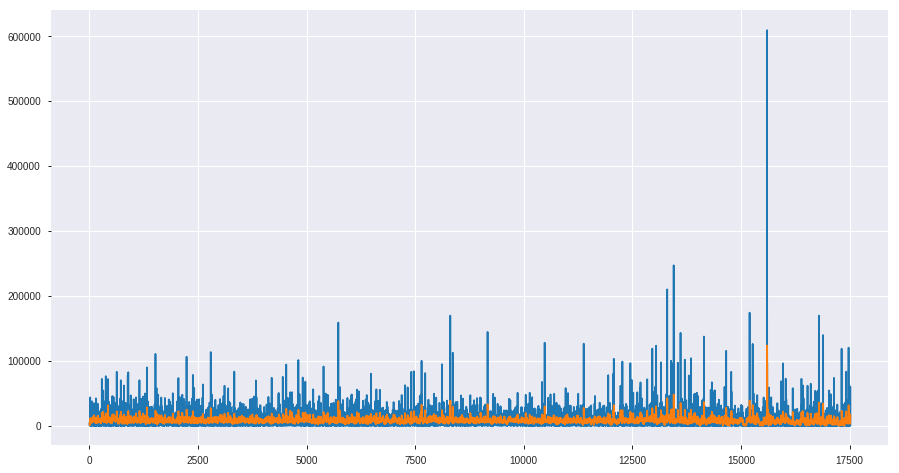

Col198 12406


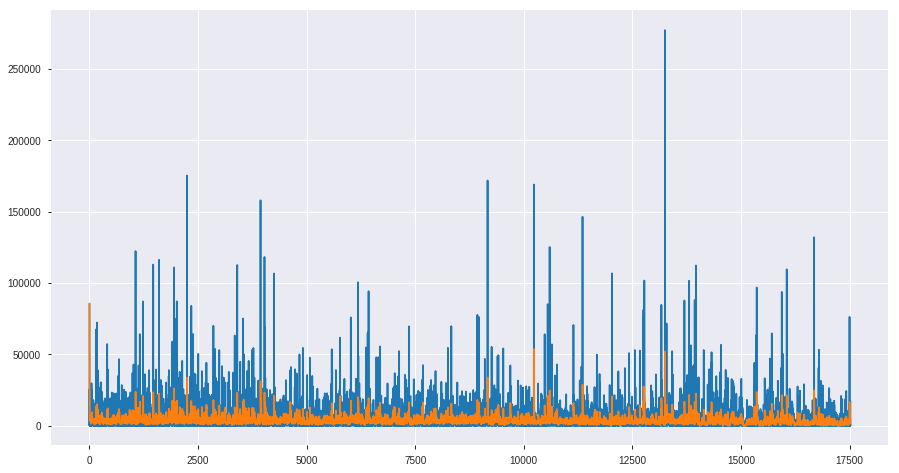

Col202 5981


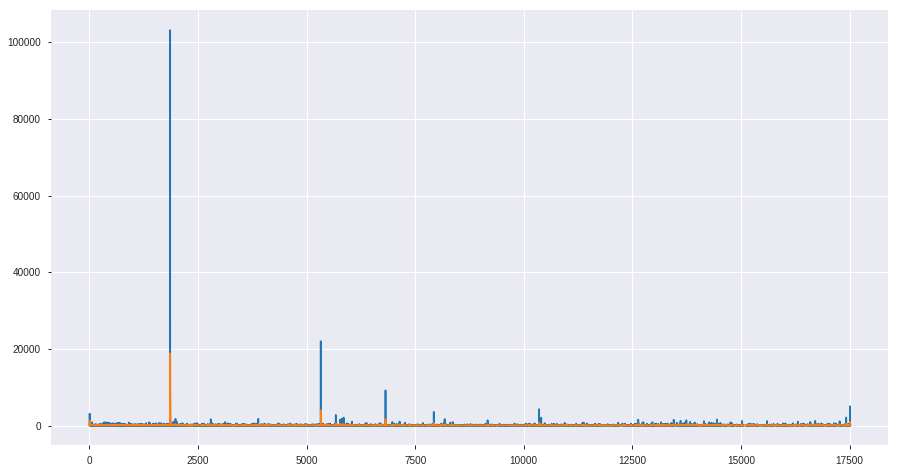

Col205 4629


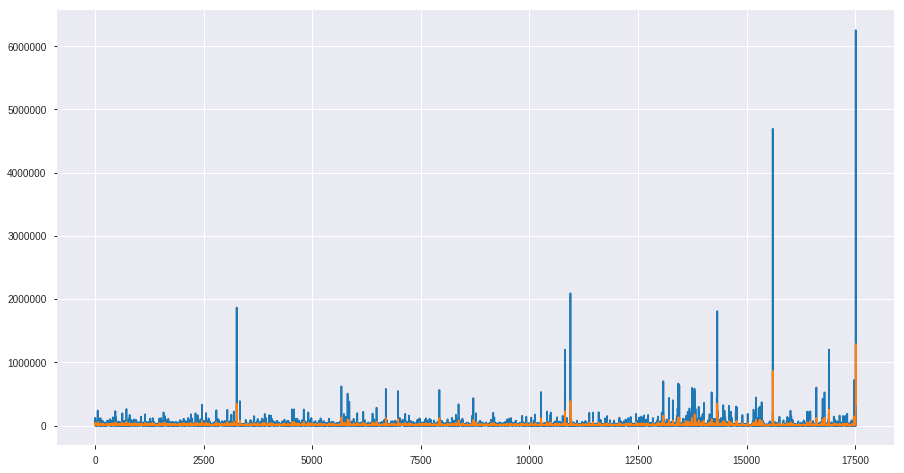

Col591 10506


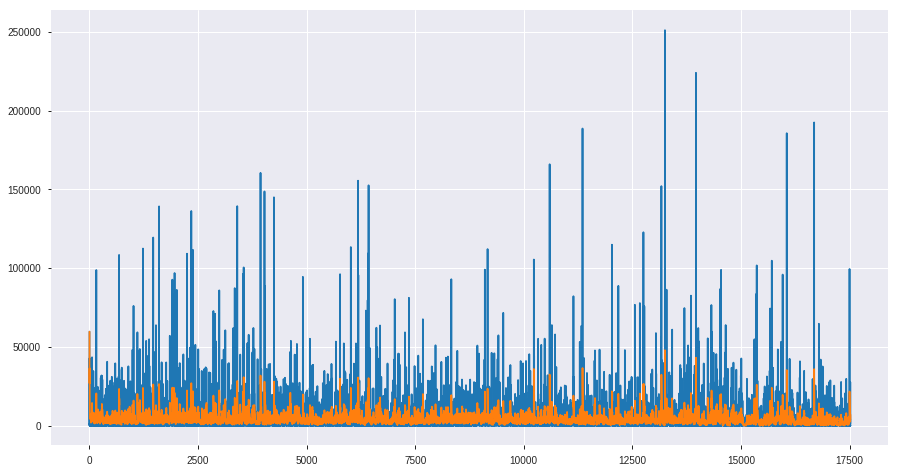

In [145]:
for i in thres_col:
    if train[i].nunique() >= 11:
        print(i, train[i].nunique())
        plt.figure(figsize=(15, 8))
        plt.plot(train[i])
        train[i] = train[i].ewm(span = 10).mean()
        plt.plot(train[i])
        plt.show()

#         print(train[i].value_counts())

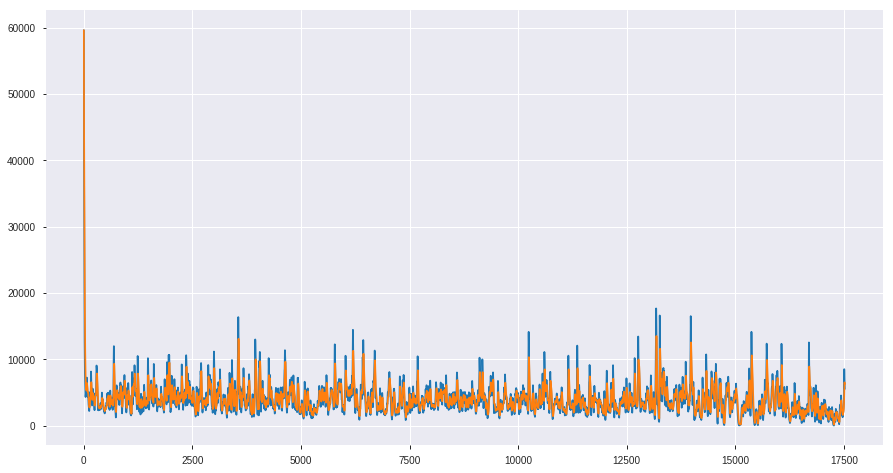

In [110]:
plt.figure(figsize=(15, 8))
colc = 'Col591'
plt.plot(train[colc])
plt.plot(train[colc].ewm(span = 20).mean())

Col10 19158


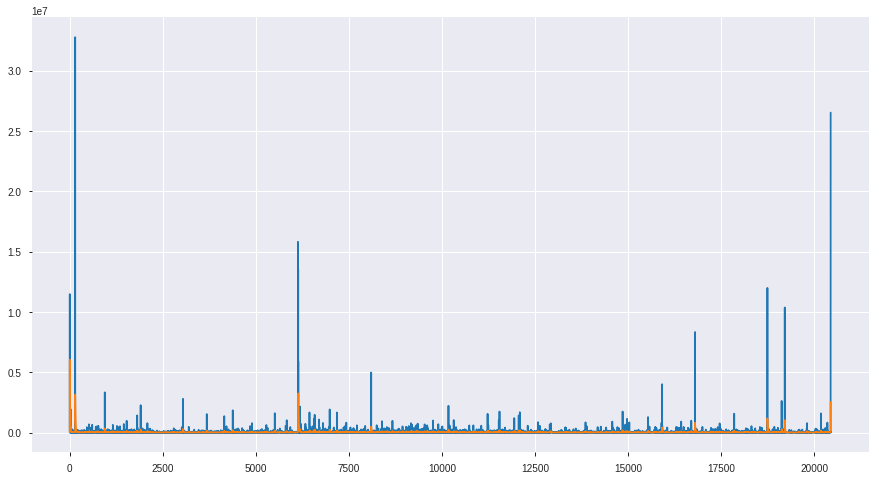

Col11 19146


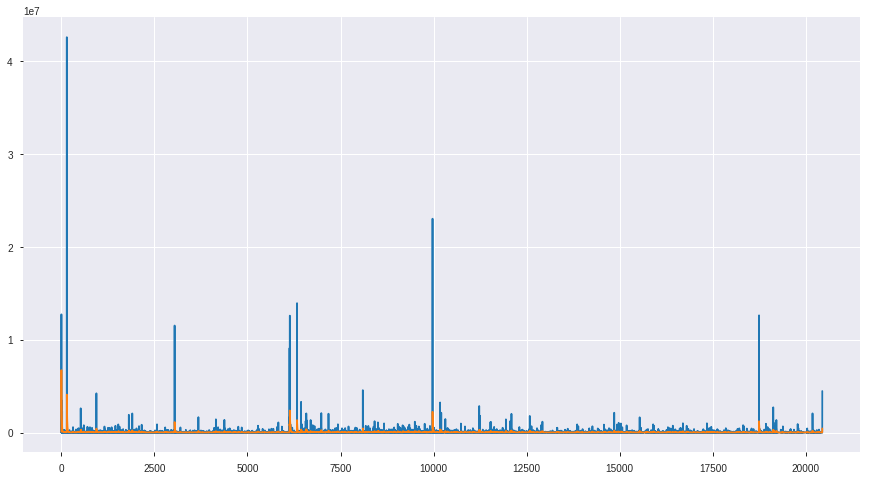

Col25 19024


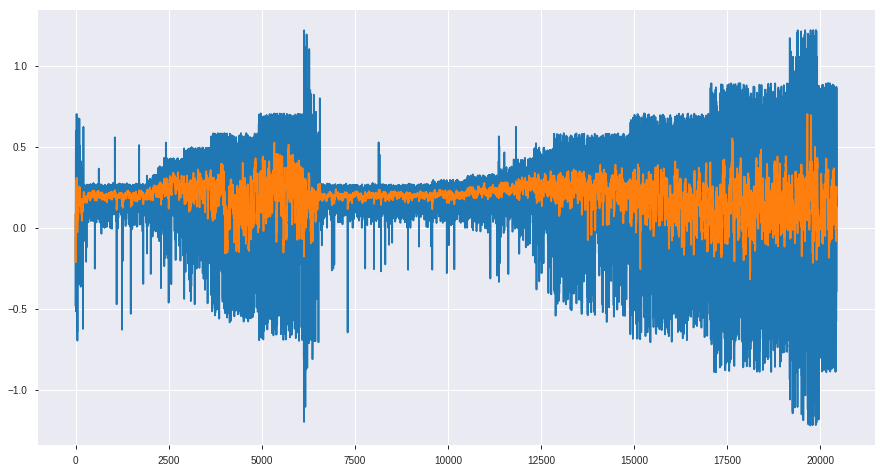

Col26 18965


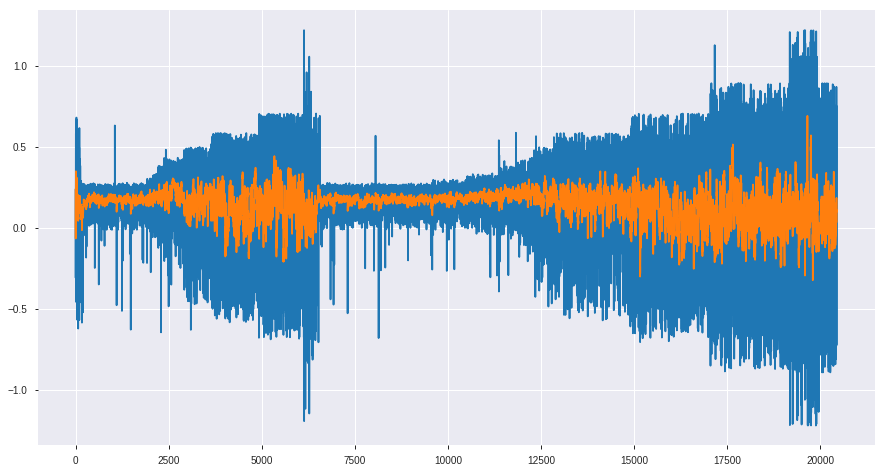

Col168 19003


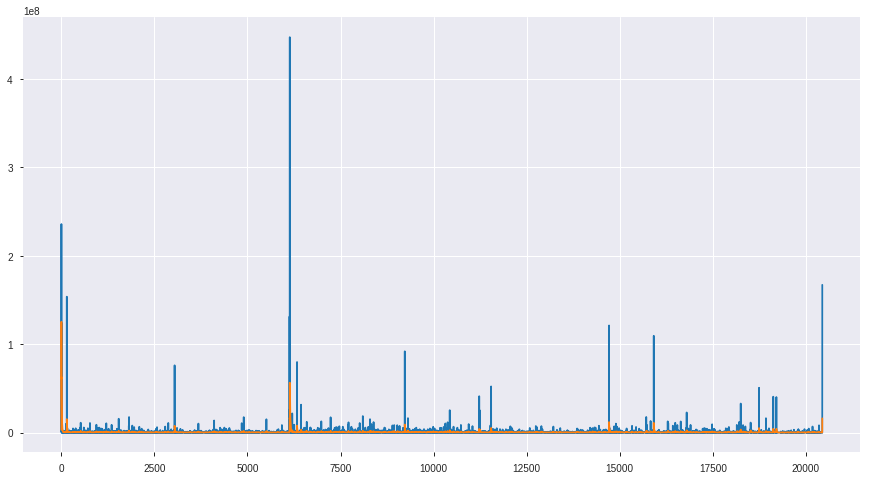

Col182 823


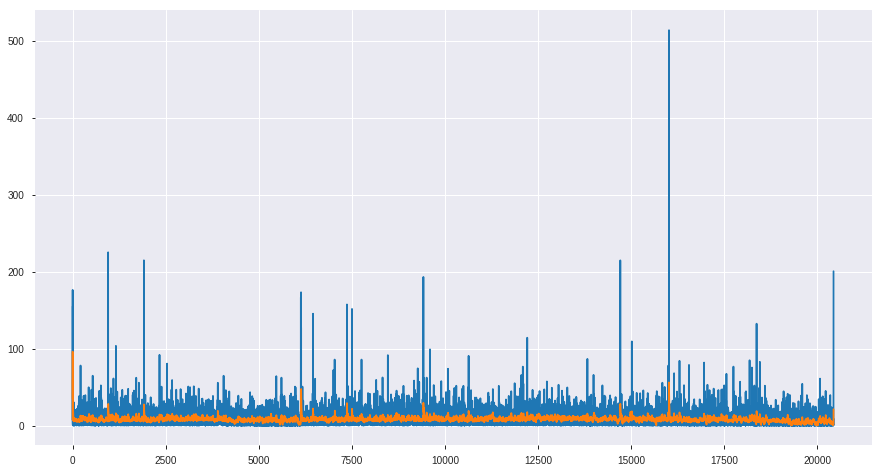

Col186 323


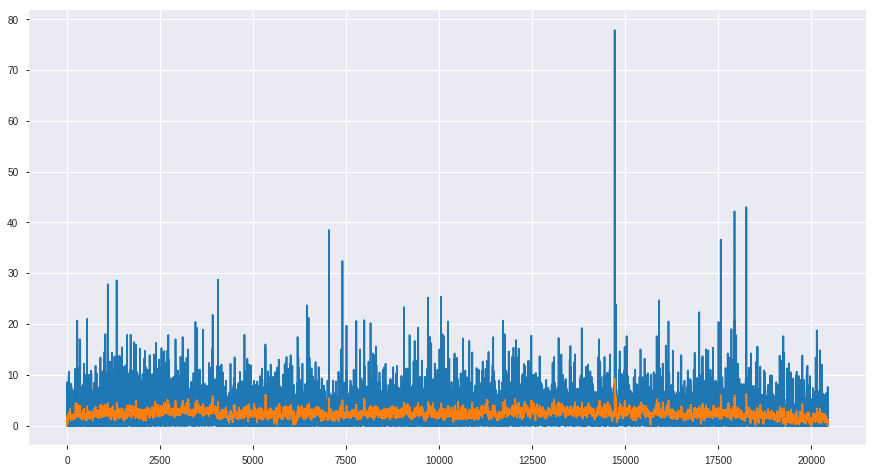

Col188 508


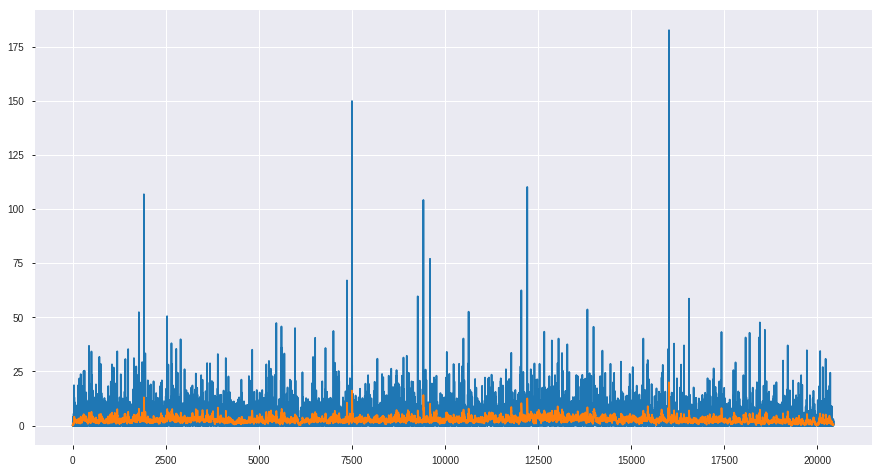

Col189 331


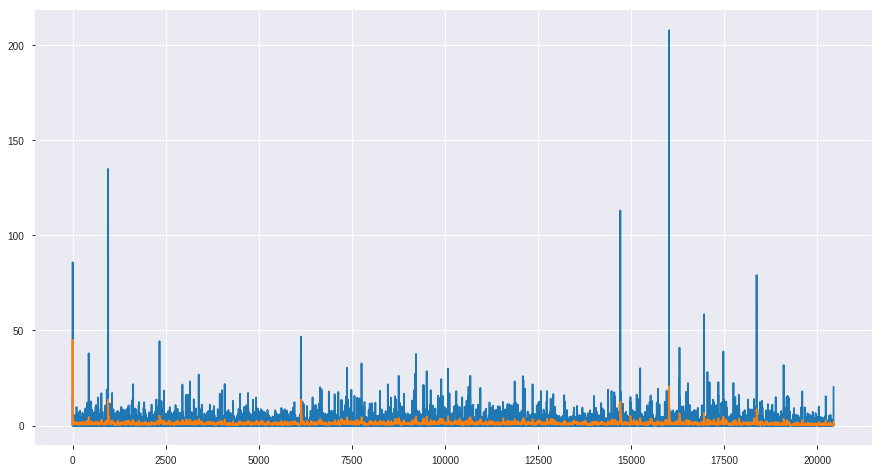

Col196 4582


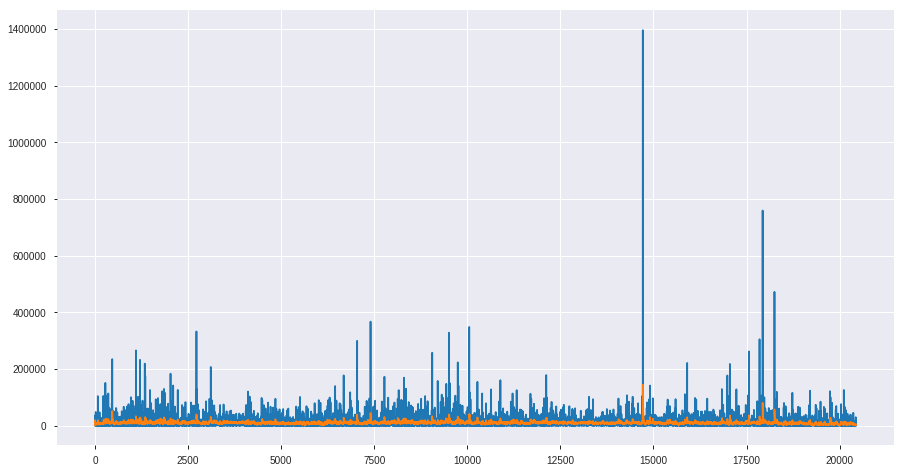

Col198 13601


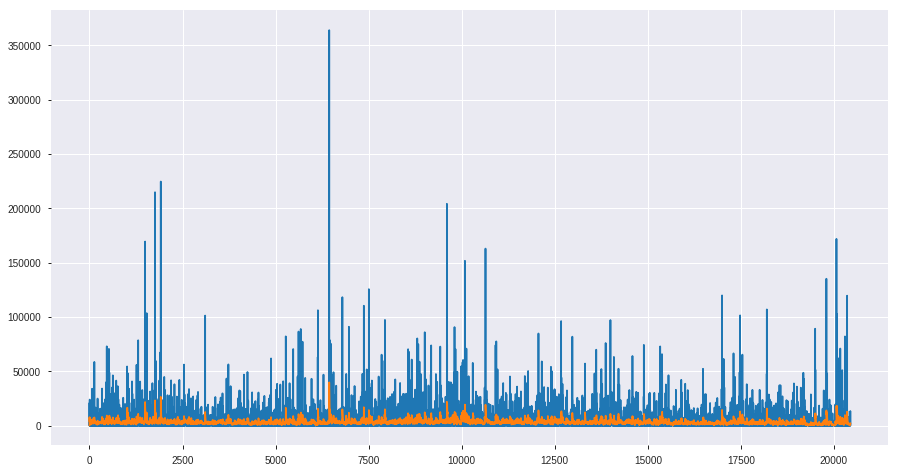

Col202 8722


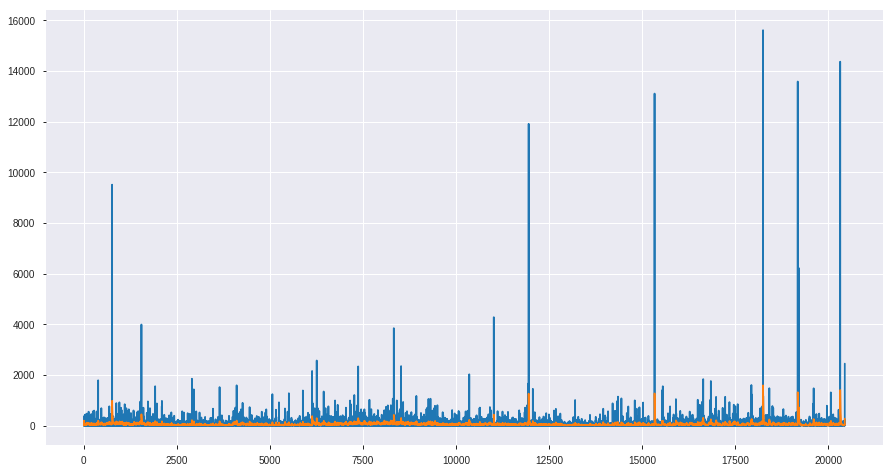

Col205 5297


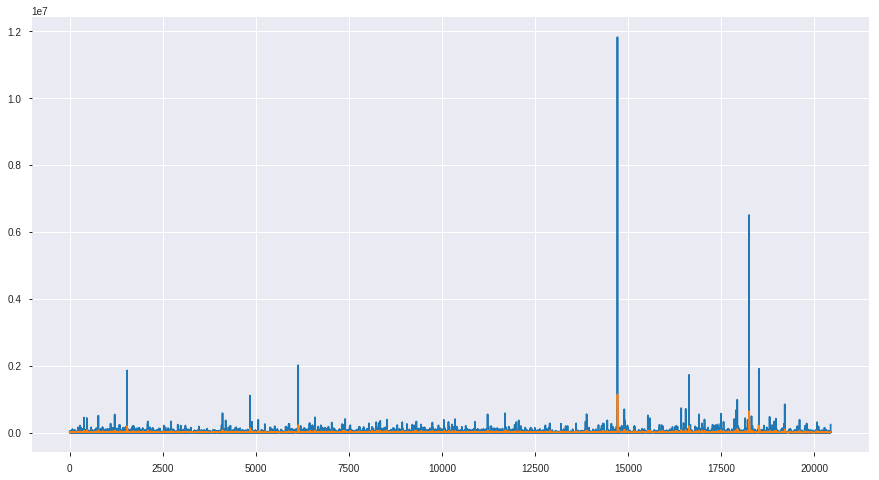

Col591 11341


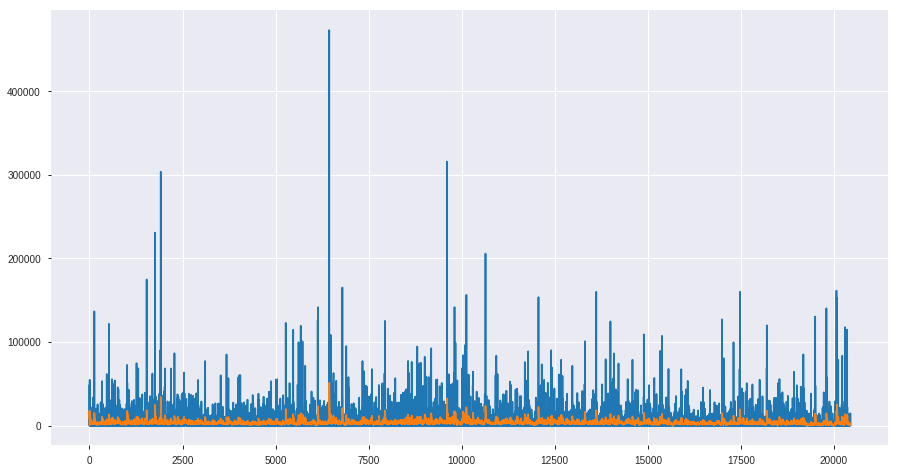

In [167]:
for i in thres_col:
    if test[i].nunique() >= 11:
        print(i, test[i].nunique())
        plt.figure(figsize=(15, 8))
        plt.plot(test[i])
        test[i] = test[i].ewm(span = 20).mean()
        plt.plot(test[i])
        plt.show()

In [147]:
lgbb = lgb.LGBMClassifier()
lgbb.fit(train[thres_col].values, train['Col2'].values)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [168]:
result = lgbb.predict(test[thres_col].values)

In [169]:
submission = pd.DataFrame()
submission['Col1'] = test['Col1']
submission['Col2'] = result

In [170]:
submission.to_csv('submission.csv', index=False)

In [171]:
submission.head()

,Col1,Col2
0,RIGD58ZWD,0
1,RIH660YDS,0
2,RIH660Q96,0
3,RIYDO15W1,0
4,RIYBGC1ZD,0


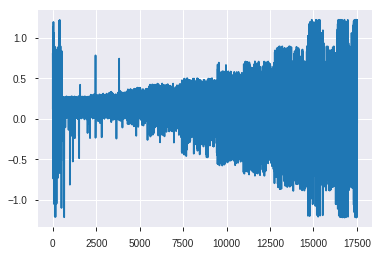

In [165]:
plt.plot(train['Col26'])

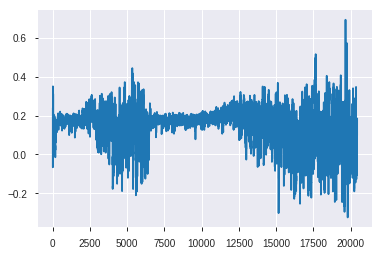

In [172]:
plt.plot(test['Col26'])